# DR CRC Model: US Natural History Calibration
Sophie Wagner, sw3767@cumc.columbia.edu

### Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps #https://csaps.readthedocs.io/en/latest/
import common_functions as func
import configs as c
import markov as m
import gof
import calibration_plots as p
import datetime as datetime

In [5]:
# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]): # for every age group (len=16), access health state (14x14) matrix
        layer=matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(matrix[age_layer], 1 - sum_of_columns)
    return matrix

def calculate_transition_probs_all_ages(params_mat):
    age_matrix = np.zeros((len(c.ages),len(c.health_states),len(c.health_states)))
    
    for age_layer in range(age_matrix.shape[0]):
        for idx, (from_state, to_state) in enumerate(c.points):
            params = params_mat[idx]
            age_matrix[age_layer,from_state,to_state] = func.get_tp(params, age_layer)

    return age_matrix

def calculate_single_transition_prob_from_logistic(params):
    return [func.get_tp(params, age_index) for age_index in c.ages]

def initialize_params():
    # Logis parameters: base, increase, offset, spread
    params = np.zeros((len(c.points),4))
    params[0] = [0.005, 0.001, 50, 0.1] # Healthy to LR    
    params[1] = [0.015, 0.001, 50, 0.1] # LR to HR
    params[2] = [0.05, 0.001, 50, 0.1] # HR to uLoc
    params[3] = [0.45, 0.001, 50, 0.1] # uLoc to uReg
    params[4] = [0.50, 0.001, 50, 0.1] # uReg to uDis
    params[5] = [0.20, 0.001, 50, 0.1] # uLoc to dLoc
    params[6] = [0.60, 0.001, 50, 0.1] # uReg to dReg
    params[7] = [0.90, 0.001, 50, 0.1] # uDis to dDis

    return params

def constrain_params(params):
    params[0,-1] = max(params[0,-1],0.00001)
    
def create_matrix(model, params=None):
    if params is None:
        params = initialize_params()
        
    matrix = calculate_transition_probs_all_ages(params) 
    matrix = add_acm(matrix)
    matrix = add_csd(matrix)
    matrix = row_normalize(matrix)
    
    return matrix

def constrain_matrix(matrix):
    matrix = np.clip(matrix,0.0,0.6)

    # Progression Block
    matrix[:,0,1] = np.maximum(0.000001, matrix[:,0,1])  # not below 0
    matrix[:,0,1] = np.minimum(matrix[:,0,1], matrix[:,1,2]) 
    
    # Detection Block
    matrix[:,3,6] = np.maximum(0, matrix[:,3,6])  # not below 0
    matrix[:,4,7] = np.maximum(matrix[:,3,6], matrix[:,4,7])  # P[d_reg] > P[d_loc]
    matrix[:,5,8] = np.maximum(matrix[:,4,7], matrix[:,5,8])  # P[d_dis] > P[d_reg]
    
    return matrix


def add_acm(matrix):
    matrix[:,0,10] = c.acm_rate  # Healthy to ACM
    matrix[:,1:3,12] = c.acm_rate[:, np.newaxis] # Polyp to ACM
    matrix[:,3:6,13] = c.acm_rate[:, np.newaxis] # Undiagnosed to ACM
    matrix[:,6:9,11] = c.acm_rate[:, np.newaxis]  # Cancer to ACM
    
    matrix[:,9,9] = 1  # Stay in CSD
    matrix[:,10,10] = 1  # Stay in ACM
    matrix[:,11,11] = 1  # Stay in Cancer ACM
    matrix[:,12,12] = 1  # Stay in Polyp ACM
    matrix[:,13,13] = 1  # Stay in uCRC ACM

    return matrix 

def add_csd(matrix):
    matrix[:, 6, 9] = c.csd_rate[:, 0]
    matrix[:, 7, 9] = c.csd_rate[:, 1]
    matrix[:, 8, 9] = c.csd_rate[:, 2]
    return matrix

def interp_matrix(matrix):
    age_mids = np.arange(0,65)
    np.append(age_mids, 100)
    all_ages = c.ages
    interp_points = c.points[1:]
        
    for (from_state, to_state) in interp_points: 
        # interpolate based on parameters up to age 85
        # anchor based on the mean of these parameter values
        under_85 = matrix[:, from_state, to_state]
        anchored = np.concatenate(under_85, np.mean(under_85))
        tsmooth_spline = csaps(age_mids, anchored, smooth=.001)
        matrix[:,from_state,to_state] = tsmooth_spline(all_ages).clip(0.000001,0.6)

    return matrix

def step(params, matrix, step_size, num_adj=21):
    new_matrix = np.copy(matrix)
    new_params = np.copy(params)
    step_mat = np.random.choice(len(c.points), size=num_adj, replace=True)
    step_age = np.random.choice(len(c.ages), size = num_adj, replace=True)

    for i in range(num_adj):
        if step_mat[i] == 0:
            param_change = np.random.choice(len(params.shape[0]))
            param_base = new_params[0,0] 
            new_params[0,param_change] += np.random.uniform(low=-step_size*param_base, high=step_size*param_base)
            new_params = constrain_params(new_params)
            new_matrix[:,0,1] = calculate_single_transition_prob_from_logistic(new_params[0])
            new_matrix[:,0,1] = [func.probtoprob(tp) for tp in new_matrix[:,0,1]]
        else:
            new_matrix[step_age[i], c.points[step_mat[i]][0], c.points[step_mat[i]][1]] += np.random.uniform(low=-step_size, high=step_size)
    
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = interp_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_params, new_matrix

def simulated_annealing(n_iterations, step_size, start_pmat=None, start_tmat=None, n_adj=7, verbose=False):
    if start_tmat is None or start_pmat is None:
        raise ValueError("Need both pmat and tmat")
    else:
        best_p = np.copy(start_pmat)
        best_t = np.copy(start_tmat)
    best_log = m.run_markov_new(best_t)
    best_eval = gof.objective(best_log,1)  # evaluate the initial point
    curr_p, curr_t, curr_eval = best_p, best_t, best_eval  # current working solution
    
    for i in range(n_iterations):  
        # Run model 
        candidate_p, candidate_t = np.copy(curr_p), np.copy(curr_t)
        candidate_p, candidate_t = step(candidate_p, step_size, n_adj)
        candidate_log = m.run_markov_new(candidate_t)
        candidate_eval = gof.objective(candidate_log,i)  # Evaluate candidate point
        
        # Update "best" if better than candidate
        if candidate_eval < best_eval:
            best_p, best_t, best_eval = np.copy(candidate_p), np.copy(candidate_t), np.copy(candidate_eval) 
            best_log = m.run_markov_new(best_t)
        # t = 10 / float(i+1)  # calculate temperature for current epoch
        t = 1 /(1+np.log(i+1))
        
        # Progress report
        if verbose and i%500==0:
            inc_log=best_log[3]
            total_dxd=np.sum(inc_log[6:9,:])/c.N 
            print(i, ": ", best_eval,"   CRC: ", round(total_dxd,5))

        # Check if we should update "curr"
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion        
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_p, curr_t, curr_eval = candidate_p, candidate_t, candidate_eval  # store the new current point
        
    print(best_eval)
    return best_p, best_t

## Run Calibration

In [49]:
pmat, tmat = create_matrix()
result = simulated_annealing(20000, 1, start_pmat=pmat, start_tmat=tmat, n_adj=15, verbose=True)
result = simulated_annealing(50000, 0.5, start_pmat=result[0], start_tmat=result[1], n_adj=15, verbose=True)
#result = simulated_annealing(20000, 0.001, start_pmat=result[0], start_tmat=result[1], n_adj=7, verbose=True)

0 :  147571.67168061587    CRC:  0.05363


C:\Users\sophi\AppData\Local\Temp\ipykernel_44852\2549628948.py:297: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion


500 :  104819.0785430582    CRC:  0.0612
1000 :  103103.1156928779    CRC:  0.06133
1500 :  94031.9149744471    CRC:  0.06487
2000 :  94031.9149744471    CRC:  0.06487
2500 :  94031.9149744471    CRC:  0.06487
3000 :  90188.12809926749    CRC:  0.06677
3500 :  89687.96603752235    CRC:  0.06593
4000 :  87647.26966365668    CRC:  0.06718
4500 :  87647.26966365668    CRC:  0.06718
5000 :  87361.70138513568    CRC:  0.06826
5500 :  70540.82981815489    CRC:  0.06479
6000 :  68180.20082632828    CRC:  0.06476
6500 :  67389.83349613204    CRC:  0.06572
7000 :  67107.86298172652    CRC:  0.06575
7500 :  66857.75961317666    CRC:  0.06574
8000 :  66857.75961317666    CRC:  0.06574
8500 :  65403.6155384169    CRC:  0.06268
9000 :  61691.534662414895    CRC:  0.06534
9500 :  61130.82274623103    CRC:  0.06533
10000 :  60969.329429767    CRC:  0.0653
10500 :  60304.097293853614    CRC:  0.06563
11000 :  60298.2614044923    CRC:  0.06606
11500 :  60178.878985688316    CRC:  0.06597
12000 :  60043

In [50]:
# Generate the current timestamp in the format YYYYMMDD_HHMMSS
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

curr_pmat, curr_tmat = result[0].copy(), result[1].copy()
curr_log = m.run_markov_new(curr_tmat)

# Save the numpy arrays with the timestamp in the filenames
np.save(f"../out/tmats/tmat_us_{timestamp}.npy", curr_tmat)
np.save(f"../out/logs/log_us_{timestamp}.npy", curr_log)

### Print transition probabilities

In [51]:
desired_transitions = [
    ('healthy', 'LR_polyp'),
    ('LR_polyp', 'HR_polyp'),
    ('HR_polyp', 'u_CRC_loc'),
    ('u_CRC_loc', 'u_CRC_reg'),
    ('u_CRC_reg', 'u_CRC_dis'),
    ('u_CRC_loc', 'd_CRC_loc'),
    ('u_CRC_reg', 'd_CRC_reg'),
    ('u_CRC_dis', 'd_CRC_dis')
]
# Extract transition probabilities
transition_probs = p.extract_transition_probs(curr_pmat, c.health_states, desired_transitions)
p.print_trans_probs(transition_probs)

Plot transition probabilities

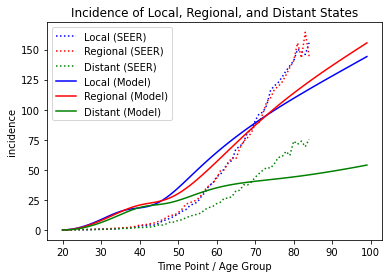

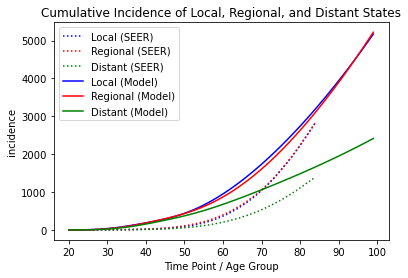

In [53]:
p.plot_tps(transition_probs)

### Compare model and SEER incidence

In [ ]:
p.plot_vs_seer(curr_log, c.seer_inc)
p.plot_vs_seer_total(curr_log, c.seer_inc)

### Inspect prevalences by health state